In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
from analysis_utilities import aggregate_by_time_and_plot, aggregate_by_event_time_and_plot, \
    select_controls, test_balance, add_missing_indicators, prepare_df, generate_variable_names

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/crime_analysis.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/crime_200m/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/crime_200m/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

analysis='group_0_crimes_50m'

In [2]:
import numpy as np

value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = generate_variable_names(analysis=analysis)

# Uncomment below line for "any crime" analysis
# df[value_vars_crime] = np.where(df[value_vars_crime] > 0, 1, 0)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis, output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                            Crime Incidents Within 50m, Oct. 2022   
                                                 \emph{Independent Variable}                                                        
Panel A: Pre-treatment Outcomes                  twenty_seventeen_group_0_crimes_50m                                 1.569791e-63   
                                                 pre_treatment_change_in_group_0_crimes_50m                          2.199695e-01   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                  9.477080e-02   
                                                 job_density_2013                                                    3.550933e-06   
                                                 med_hhinc2016                                                       7.326600e-01   
                                                 poor_share2010                                                      5.044107e-01   
                                                 popdensity2010                                                      3.974934e-02   
                                                 share_white2010                                                     9.608368e-01   
                                                 traveltime15_2010                                                   3.508047e-03   
Panel C: Case Initiation                         for_cause                                                           1.273045e-01   
                                                 no_cause                                                            2.380064e-01   
                                                 non_payment                                                         3.344843e-02   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                            3.353952e-01   
                                                 hasAttyP                                                            8.849589e-02   
                                                 isEntityD                                                           3.763212e-01   
                                                 isEntityP                                                           4.888745e-03   

                                                                                                               
                                                                                            Plaintiff Victory  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  twenty_seventeen_group_0_crimes_50m             1.585459e-01  
                                                 pre_treatment_change_in_group_0_crimes_50m      6.347788e-02  
Panel B: Census Tract Characteristics            frac_coll_plus2010                              2.403331e-01  
                                                 job_density_2013                                1.626836e-01  
                                                 med_hhinc2016                                   1.910501e-01  
                                                 poor_share2010                                  1.428679e-01  
                                                 popdensity2010                                  5.946111e-02  
                                                 share_white2010                                 9.829904e-02  
                                                 traveltime15_2010                               2.271578e-01  
Panel C: Case Initiation                         for_cause                                       4.801045e-01  
                                                 no_cause                                        3.835665e-05  
               

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                            Cases Won by Plaintiff   
Panel A twenty_seventeen_group_0_crimes_50m               1.427597   
Panel B job_density_2013                              16069.137185   
        popdensity2010                                23086.043553   
        traveltime15_2010                                 0.162315   
Panel C non_payment                                       0.781742   
Panel D isEntityP                                         0.808499   

                                            Difference in Cases Won by Defendant  \
                                                                      Unweighted   
Panel A twenty_seventeen_group_0_crimes_50m                            -0.203471   
Panel B job_density_2013                                             3197.929971   
        popdensity2010                                               1373.148087   
        traveltime15_2010                                               0.005986   
Panel C non_payment                                                     0.068150   
Panel D isEntityP                                                       0.099762   

                                                                             
                                             \emph{p}    Weighted  \emph{p}  
Panel A twenty_seventeen_group_0_crimes_50m  0.158546   -0.163773  0.258767  
Panel B job_density_2013                     0.162684  843.087985  0.709307  
        popdensity2010                       0.059461 -365.579339  0.577084  
        traveltime15_2010                    0.227158   -0.004366  0.341503  
Panel C non_payment                          0.002881   -0.001780  0.924700  
Panel D isEntityP                            0.000006    0.012491  0.400008

In [6]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_month_variable = treatment_date_variable.replace('date', 'month')

missing_indicators = []

# Prepare df for use with the differences package.
df = prepare_df(df, analysis, treatment_date_variable, pre_treatment_covariates, missing_indicators, value_vars_crime, month_to_int_dictionary)

In [7]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 2184/2184 [00:12<00:00, 170.20it/s]


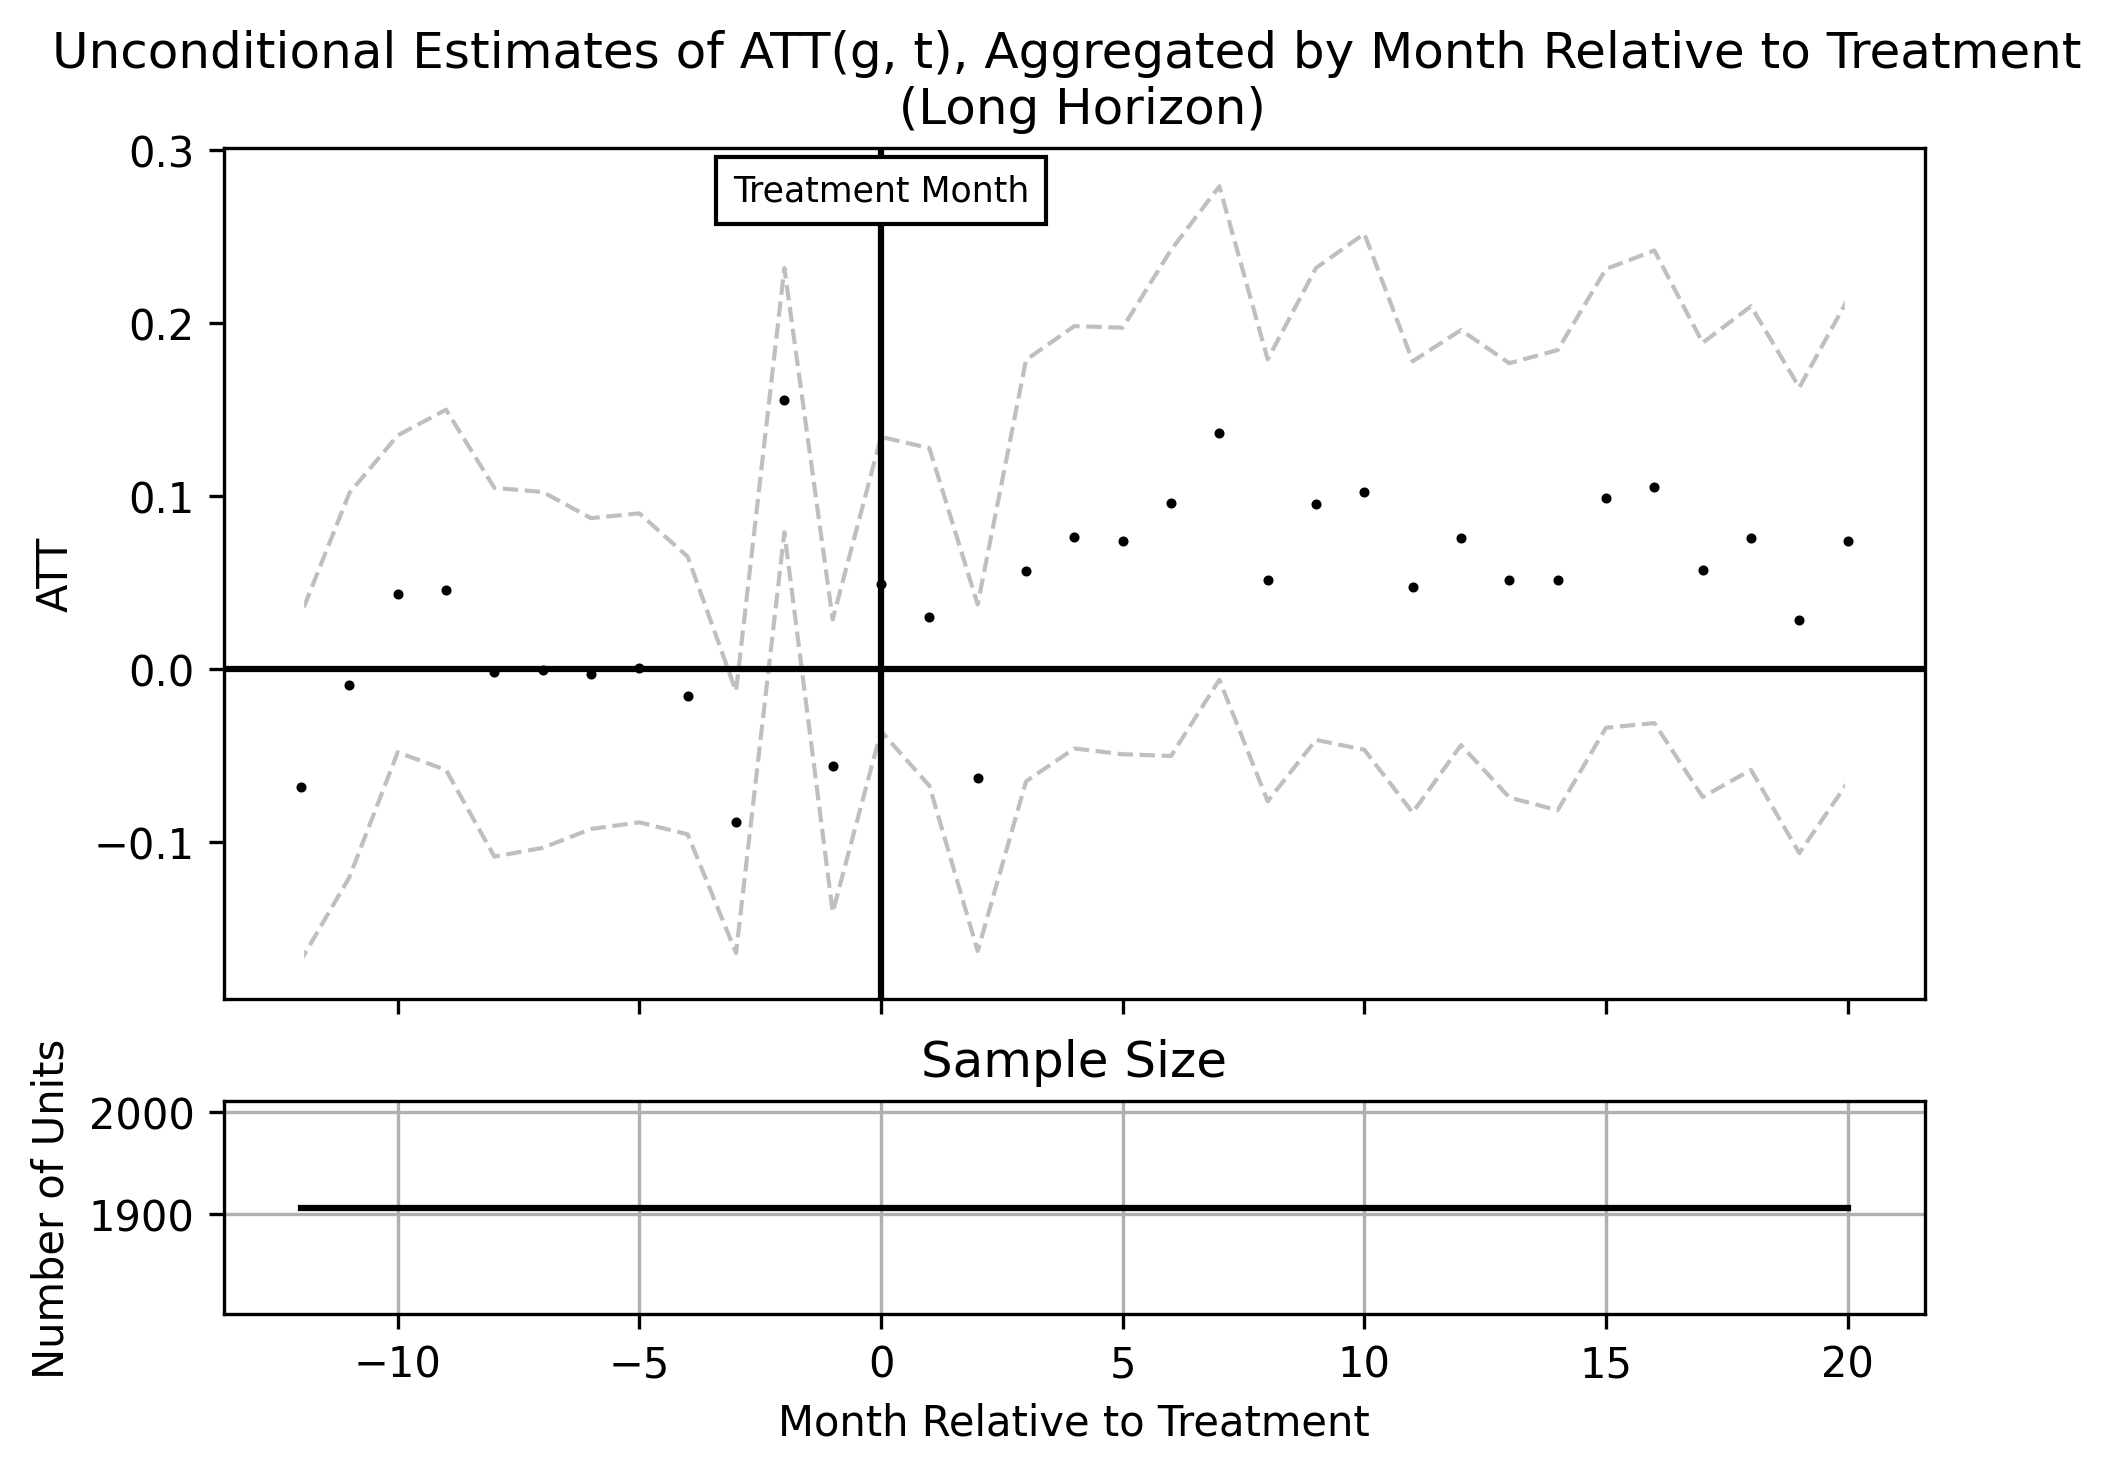

In [8]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=20,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

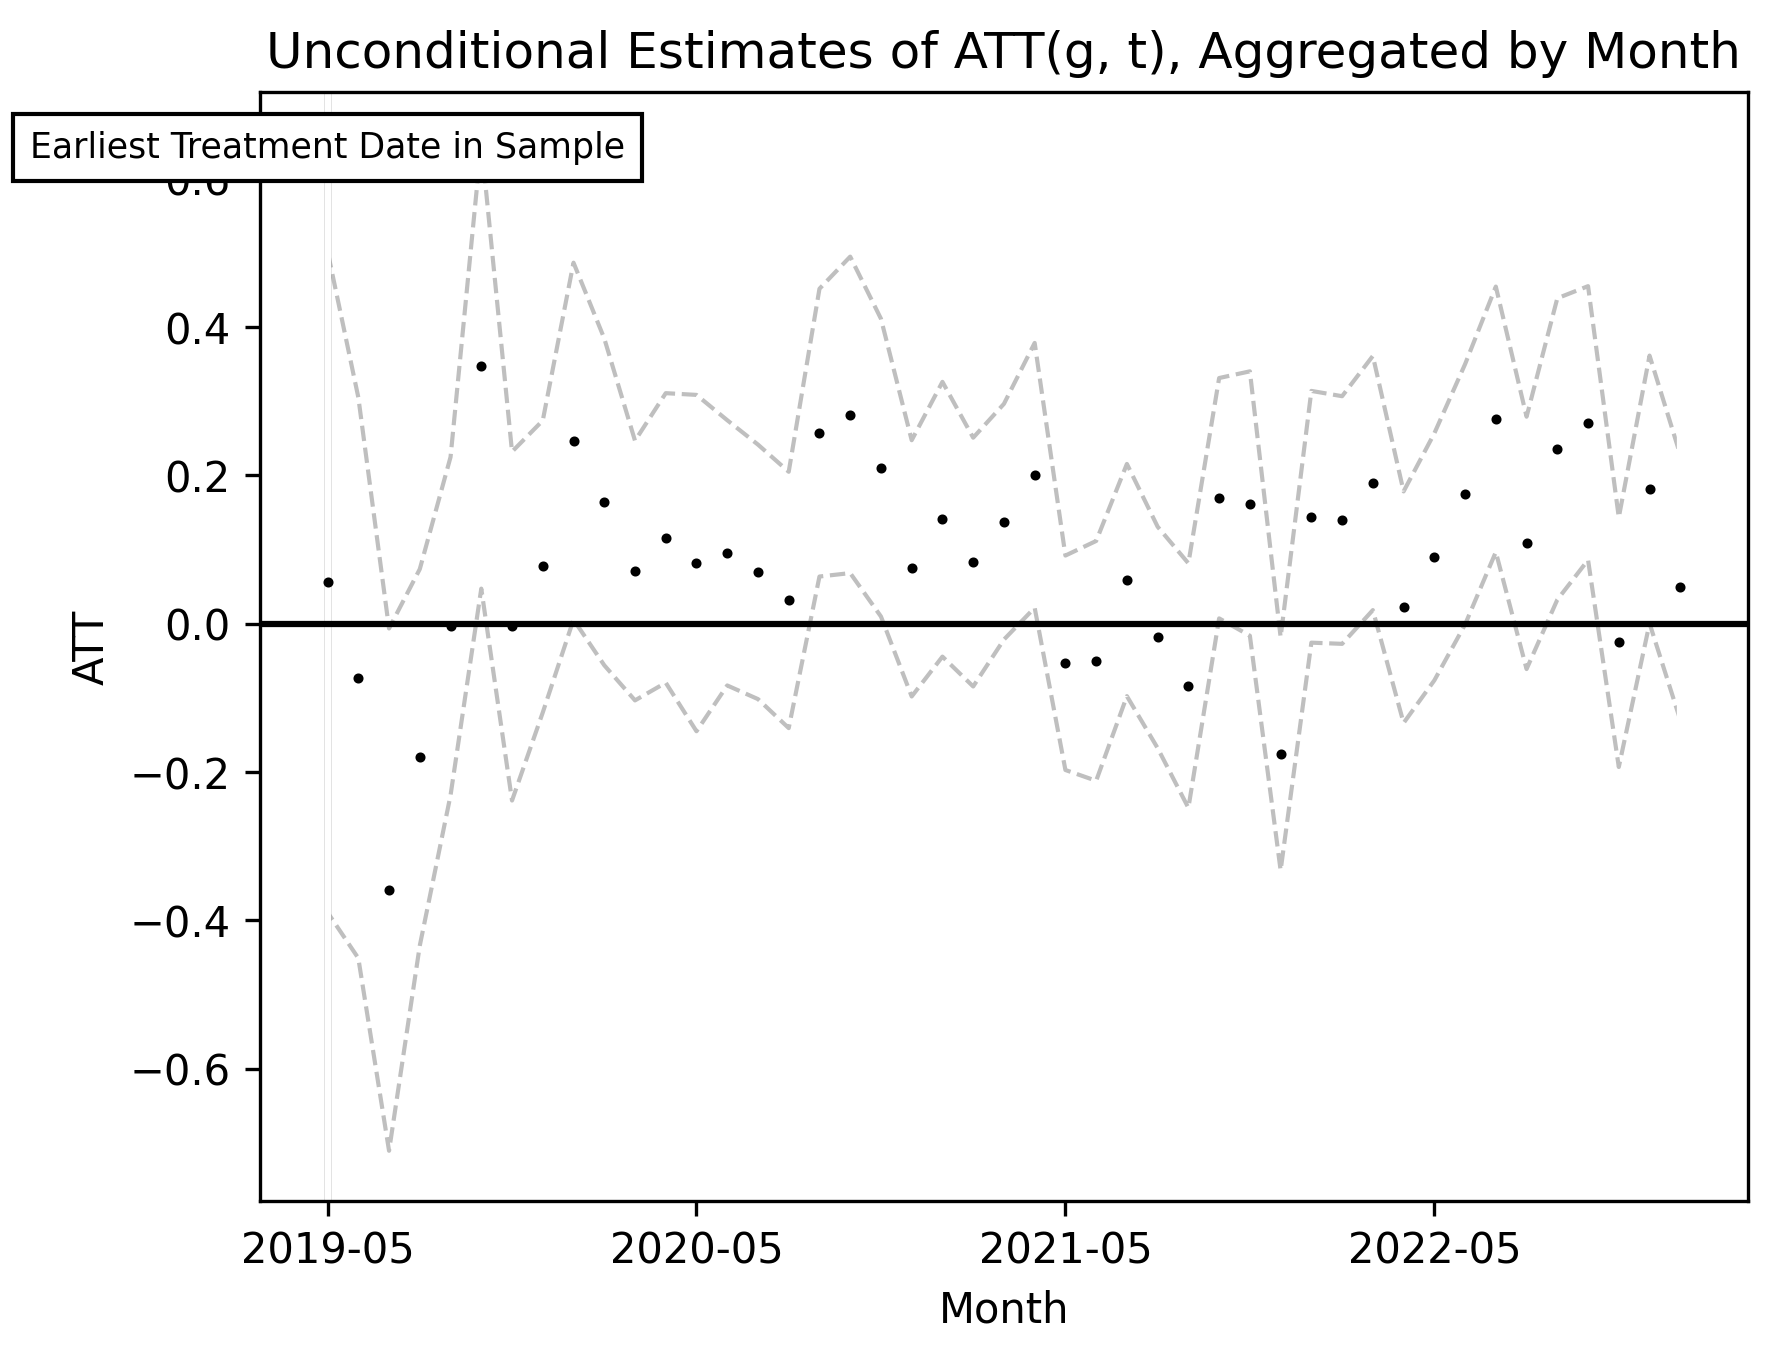

In [9]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [10]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]   62%|████████████▍       | 1356/2184 [00:15<00:08, 94.50it/s] /Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow enco

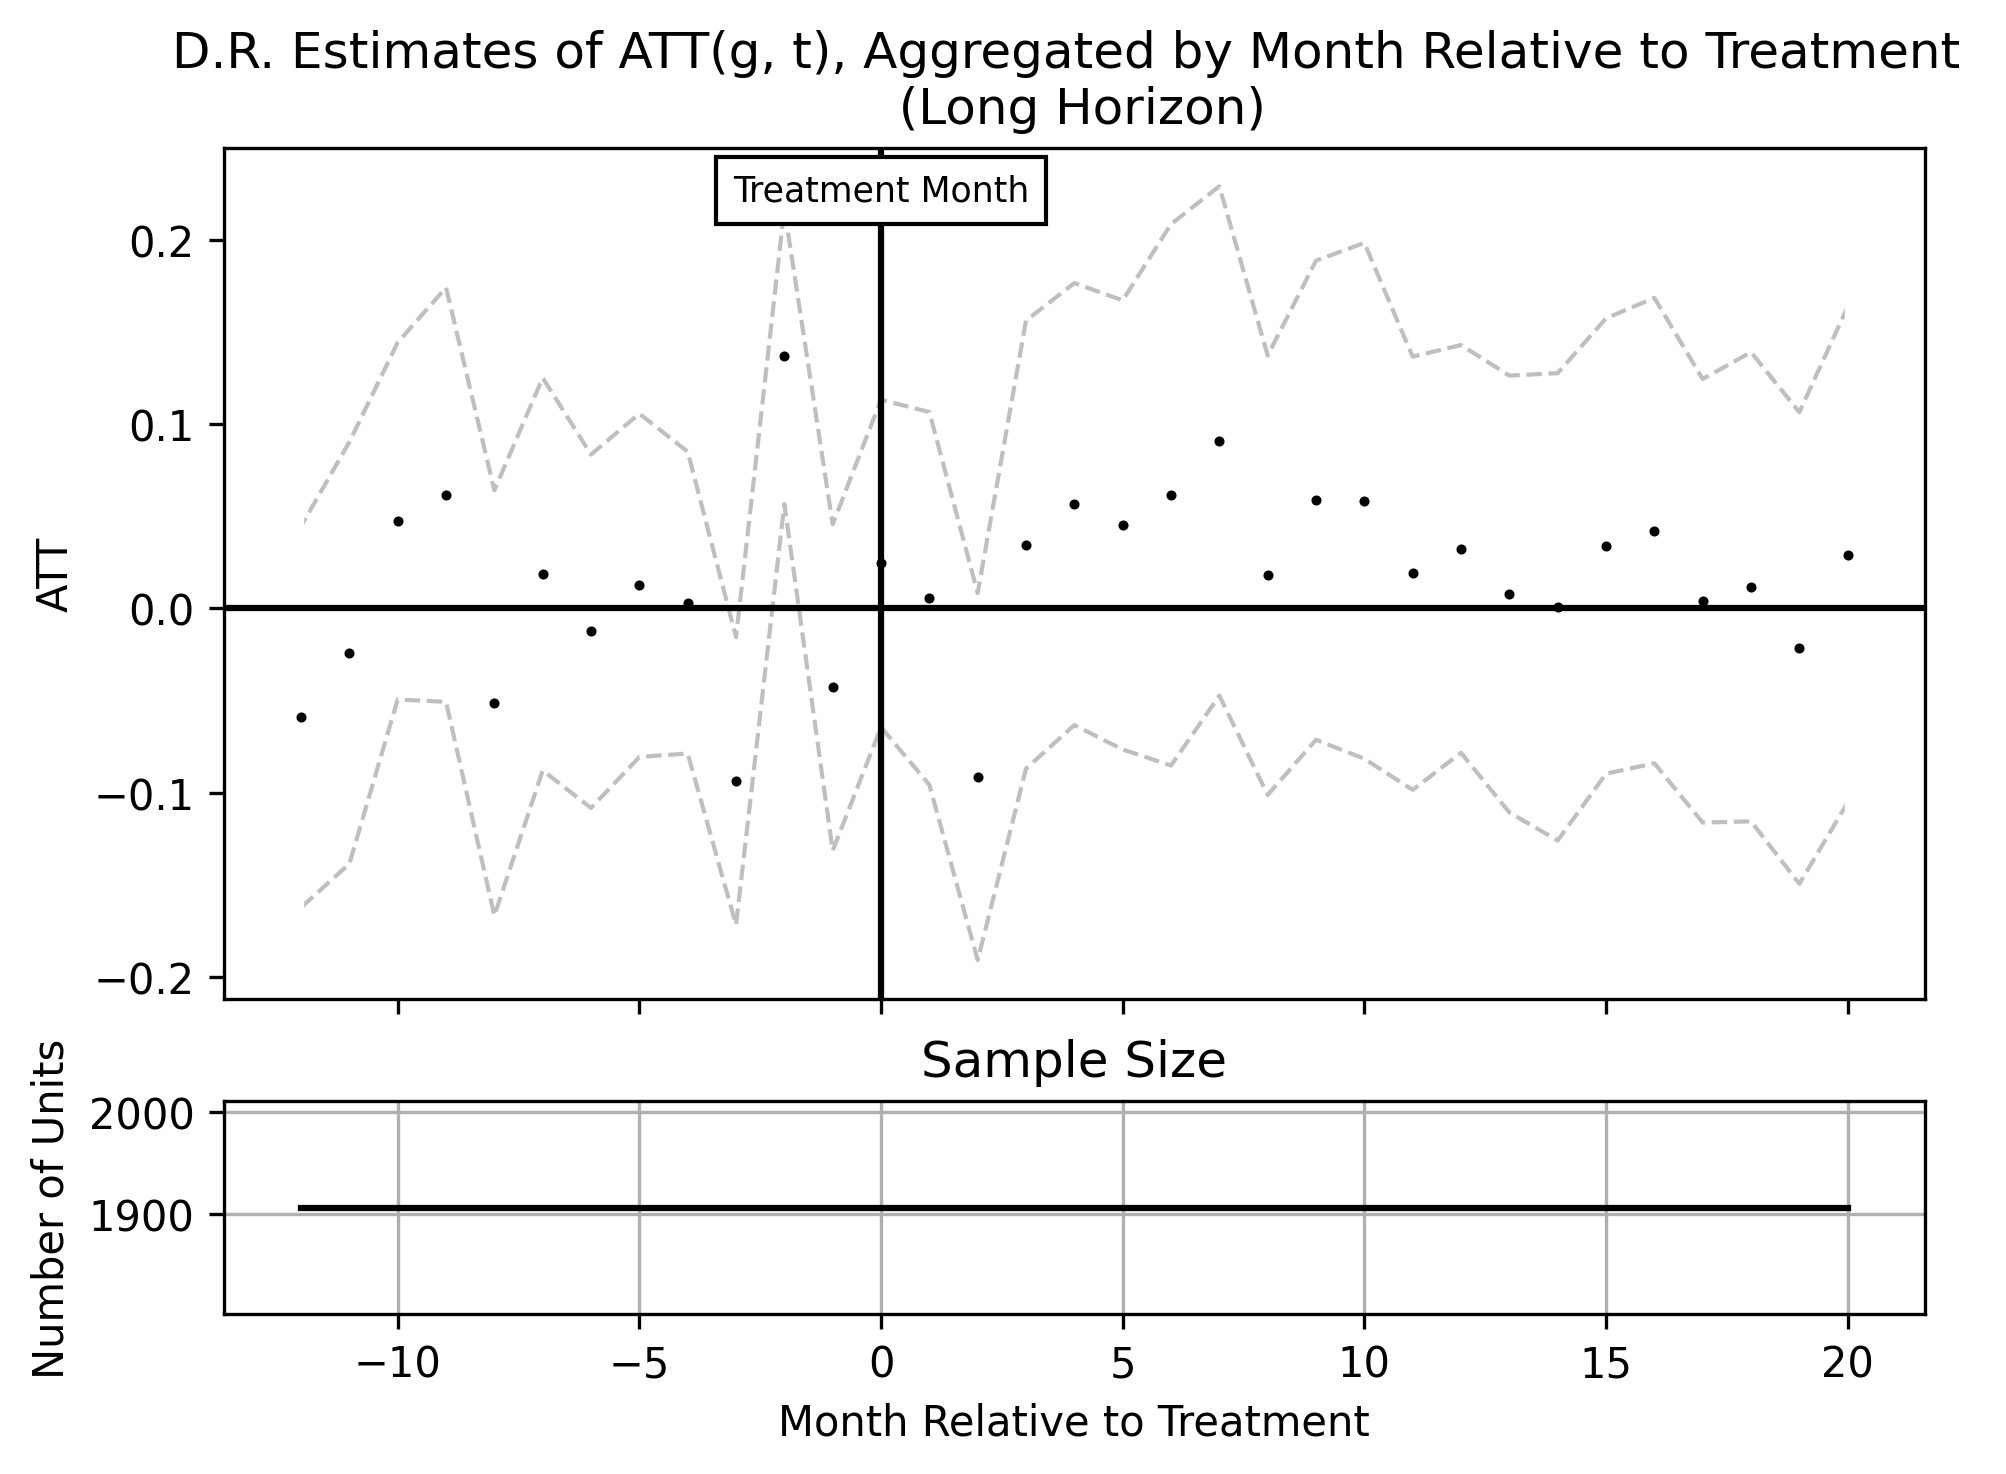

In [11]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=20,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

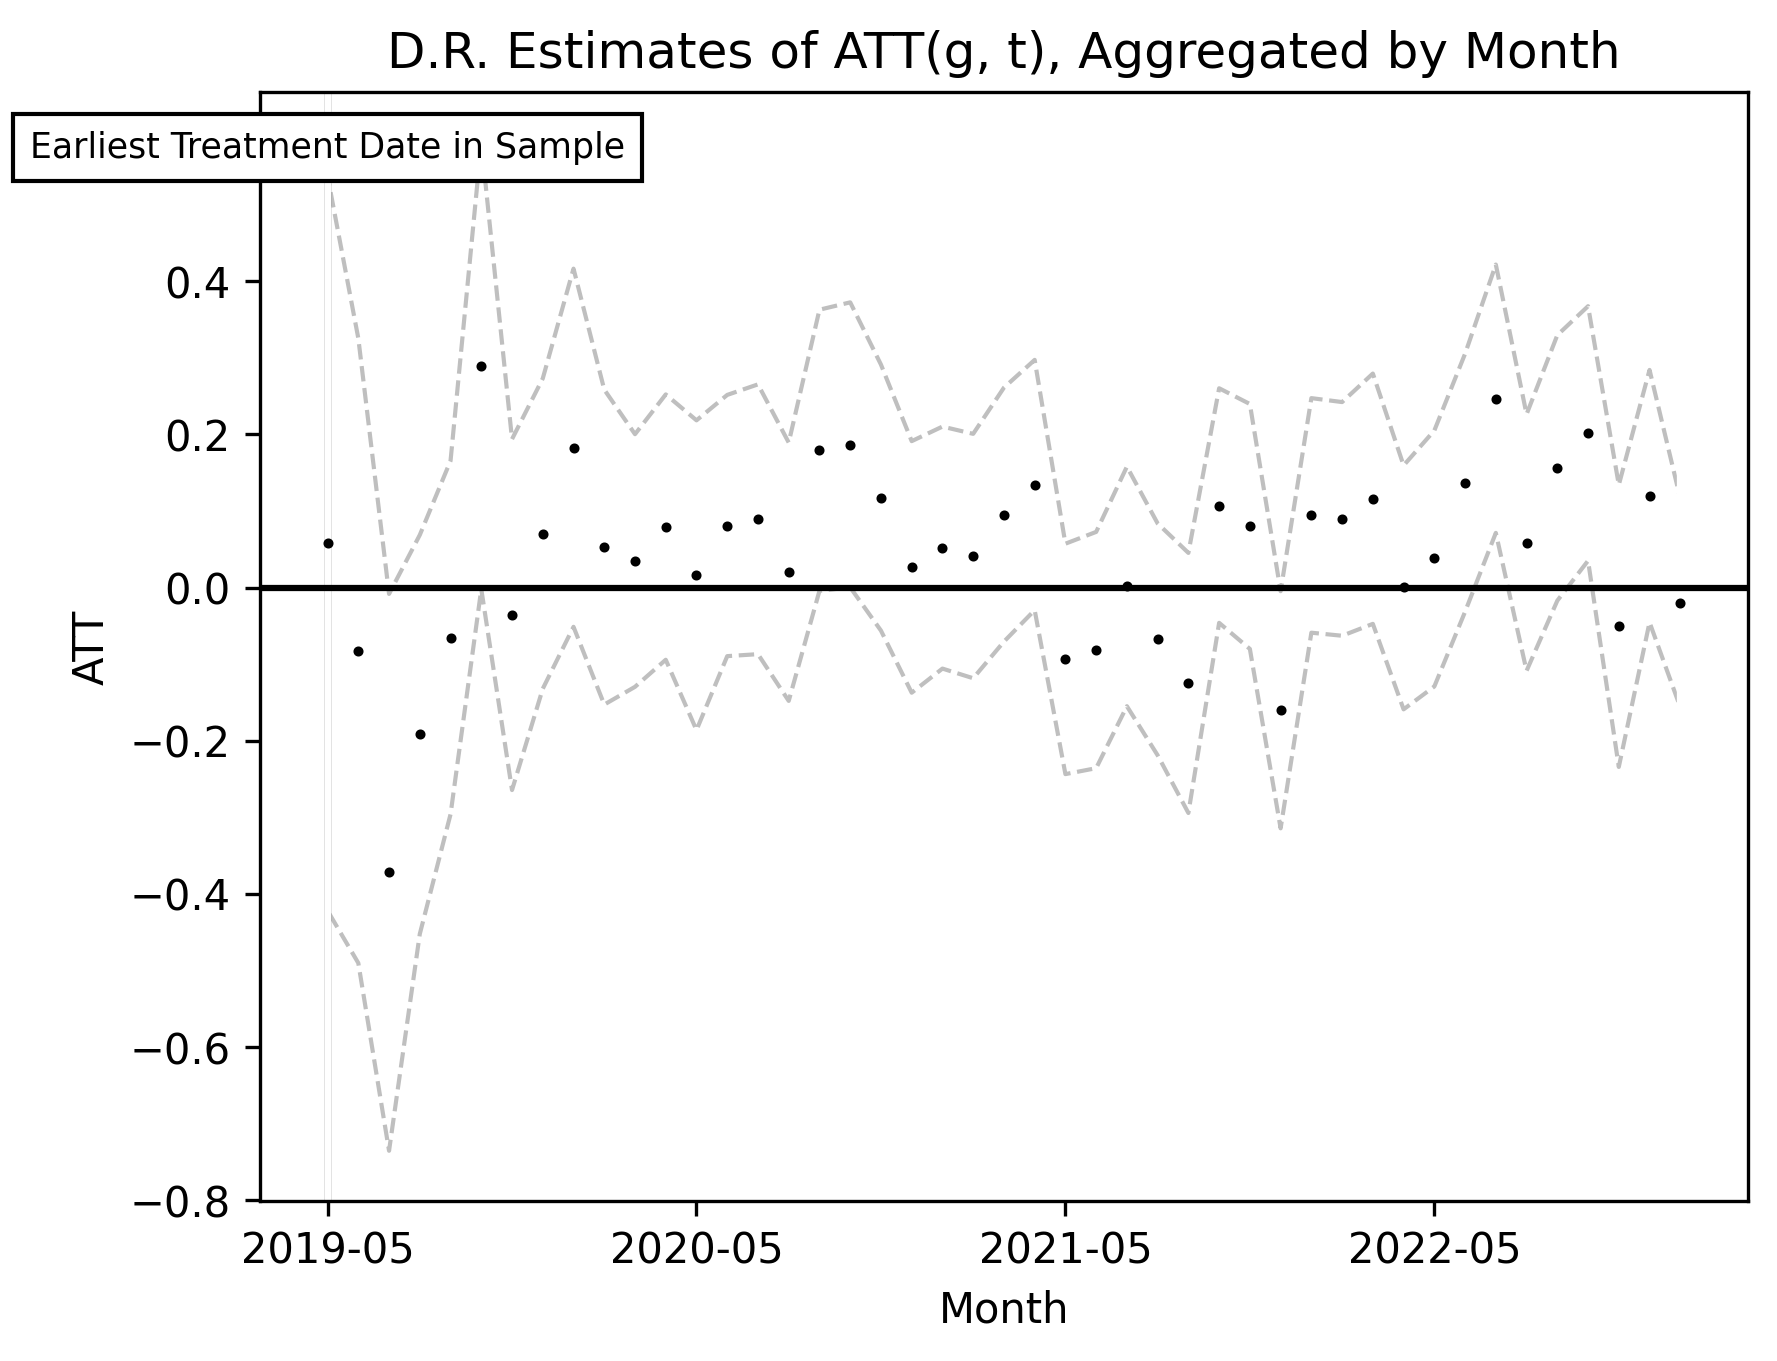

In [12]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")